# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import os
from PIL import Image
import tensorflow as tf
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Activation



In [2]:
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sklearn.__version__)
print("tensorflow:",tf.__version__)
print("tensorflow keras:",tf.keras.__version__)

numpy: 2.1.3
pandas: 2.2.3
seaborn: 0.13.2
sklearn: 1.6.1
tensorflow: 2.19.0
tensorflow keras: 3.9.2


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [24]:
# Define a function to load data and aggregate them

def load_and_aggregate_stock_data(file_list):
    dfs = []
    for file in file_list:
        # Extract stock name from file name (e.g., 'AMZN' from 'AMZN_stock_data.csv')
        stock_name = os.path.basename(file).split('_')[0]
        df = pd.read_csv(file)
        
        # Append stock name to each column except 'Date'
        df = df.rename(columns={col: f"{col}_{stock_name}" for col in df.columns})

        dfs.append(df)

    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [25]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
data_dir = "RNN_Stocks_Data"

file_list = [os.path.join(data_dir, fname) for fname in ['AMZN_stocks_data.csv', 'GOOGL_stocks_data.csv', 'IBM_stocks_data.csv', 'MSFT_stocks_data.csv']]

# for f in file_list:
# 	print(f"Exists: {os.path.exists(f)} - {f}")

master_df = load_and_aggregate_stock_data(file_list)


In [26]:
master_df.columns

Index(['Date_AMZN', 'Open_AMZN', 'High_AMZN', 'Low_AMZN', 'Close_AMZN',
       'Volume_AMZN', 'Name_AMZN', 'Date_GOOGL', 'Open_GOOGL', 'High_GOOGL',
       'Low_GOOGL', 'Close_GOOGL', 'Volume_GOOGL', 'Name_GOOGL', 'Date_IBM',
       'Open_IBM', 'High_IBM', 'Low_IBM', 'Close_IBM', 'Volume_IBM',
       'Name_IBM', 'Date_MSFT', 'Open_MSFT', 'High_MSFT', 'Low_MSFT',
       'Close_MSFT', 'Volume_MSFT', 'Name_MSFT'],
      dtype='object')

In [33]:
# View specifics of the data
def view_data(df):
    print("Data Shape:", df.shape)
    print("\nData Columns:\n", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nDescriptive Statistics:\n", df.describe())

# View the data
view_data(master_df)


Data Shape: (12077, 28)

Data Columns:
 ['Date_AMZN', 'Open_AMZN', 'High_AMZN', 'Low_AMZN', 'Close_AMZN', 'Volume_AMZN', 'Name_AMZN', 'Date_GOOGL', 'Open_GOOGL', 'High_GOOGL', 'Low_GOOGL', 'Close_GOOGL', 'Volume_GOOGL', 'Name_GOOGL', 'Date_IBM', 'Open_IBM', 'High_IBM', 'Low_IBM', 'Close_IBM', 'Volume_IBM', 'Name_IBM', 'Date_MSFT', 'Open_MSFT', 'High_MSFT', 'Low_MSFT', 'Close_MSFT', 'Volume_MSFT', 'Name_MSFT']

Data Types:
 Date_AMZN        object
Open_AMZN       float64
High_AMZN       float64
Low_AMZN        float64
Close_AMZN      float64
Volume_AMZN     float64
Name_AMZN        object
Date_GOOGL       object
Open_GOOGL      float64
High_GOOGL      float64
Low_GOOGL       float64
Close_GOOGL     float64
Volume_GOOGL    float64
Name_GOOGL       object
Date_IBM         object
Open_IBM        float64
High_IBM        float64
Low_IBM         float64
Close_IBM       float64
Volume_IBM      float64
Name_IBM         object
Date_MSFT        object
Open_MSFT       float64
High_MSFT       float

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [ ]:
# Handle Missing Values

# Check for missing values
print(master_df.isnull().sum())


Date_AMZN       9058
Open_AMZN       9058
High_AMZN       9058
Low_AMZN        9058
Close_AMZN      9058
Volume_AMZN     9058
Name_AMZN       9058
Date_GOOGL      9058
Open_GOOGL      9058
High_GOOGL      9058
Low_GOOGL       9058
Close_GOOGL     9058
Volume_GOOGL    9058
Name_GOOGL      9058
Date_IBM        9057
Open_IBM        9058
High_IBM        9057
Low_IBM         9058
Close_IBM       9057
Volume_IBM      9057
Name_IBM        9057
Date_MSFT       9058
Open_MSFT       9058
High_MSFT       9058
Low_MSFT        9058
Close_MSFT      9058
Volume_MSFT     9058
Name_MSFT       9058
dtype: int64


In [40]:
# For stock price time series data, the best way to handle missing values is usually forward fill (ffill), because:

# Stock prices and volumes are sequential and often missing due to non-trading days or data gaps.
# Forward fill uses the last known value, which is a reasonable assumption for short gaps in financial data.
# If you want to be extra safe (in case missing values are at the very start), you can also use backward fill after forward fill.

# Mean/median imputation can distort time series patterns and is not suitable for sequential financial data.

# Forward fill, then backward fill for any remaining missing values
master_df = master_df.ffill().bfill()

print(master_df.isnull().sum())


Date_AMZN       0
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Name_AMZN       0
Date_GOOGL      0
Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Name_GOOGL      0
Date_IBM        0
Open_IBM        0
High_IBM        0
Low_IBM         0
Close_IBM       0
Volume_IBM      0
Name_IBM        0
Date_MSFT       0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
Name_MSFT       0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

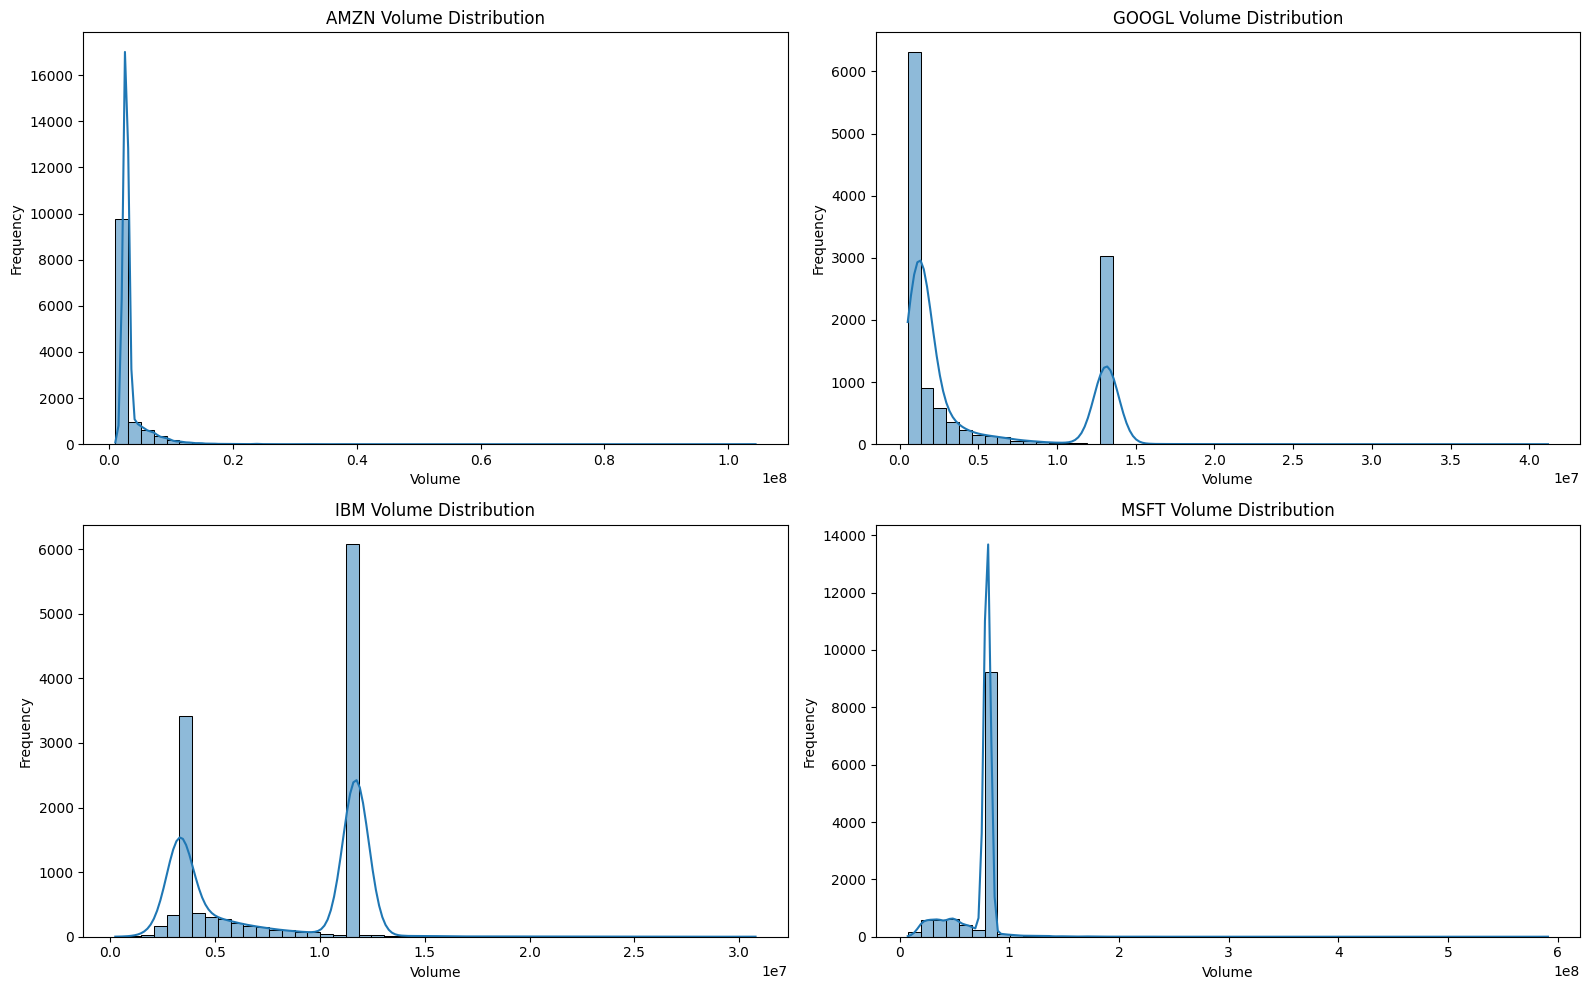

In [45]:
# Frequency distribution of volumes

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
companies = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
volume_cols = [f'Volume_{c}' for c in companies]

for ax, company, vol_col in zip(axes.flatten(), companies, volume_cols):
    sns.histplot(master_df[vol_col], bins=50, kde=True, ax=ax)
    ax.set_title(f'{company} Volume Distribution')
    ax.set_xlabel('Volume')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

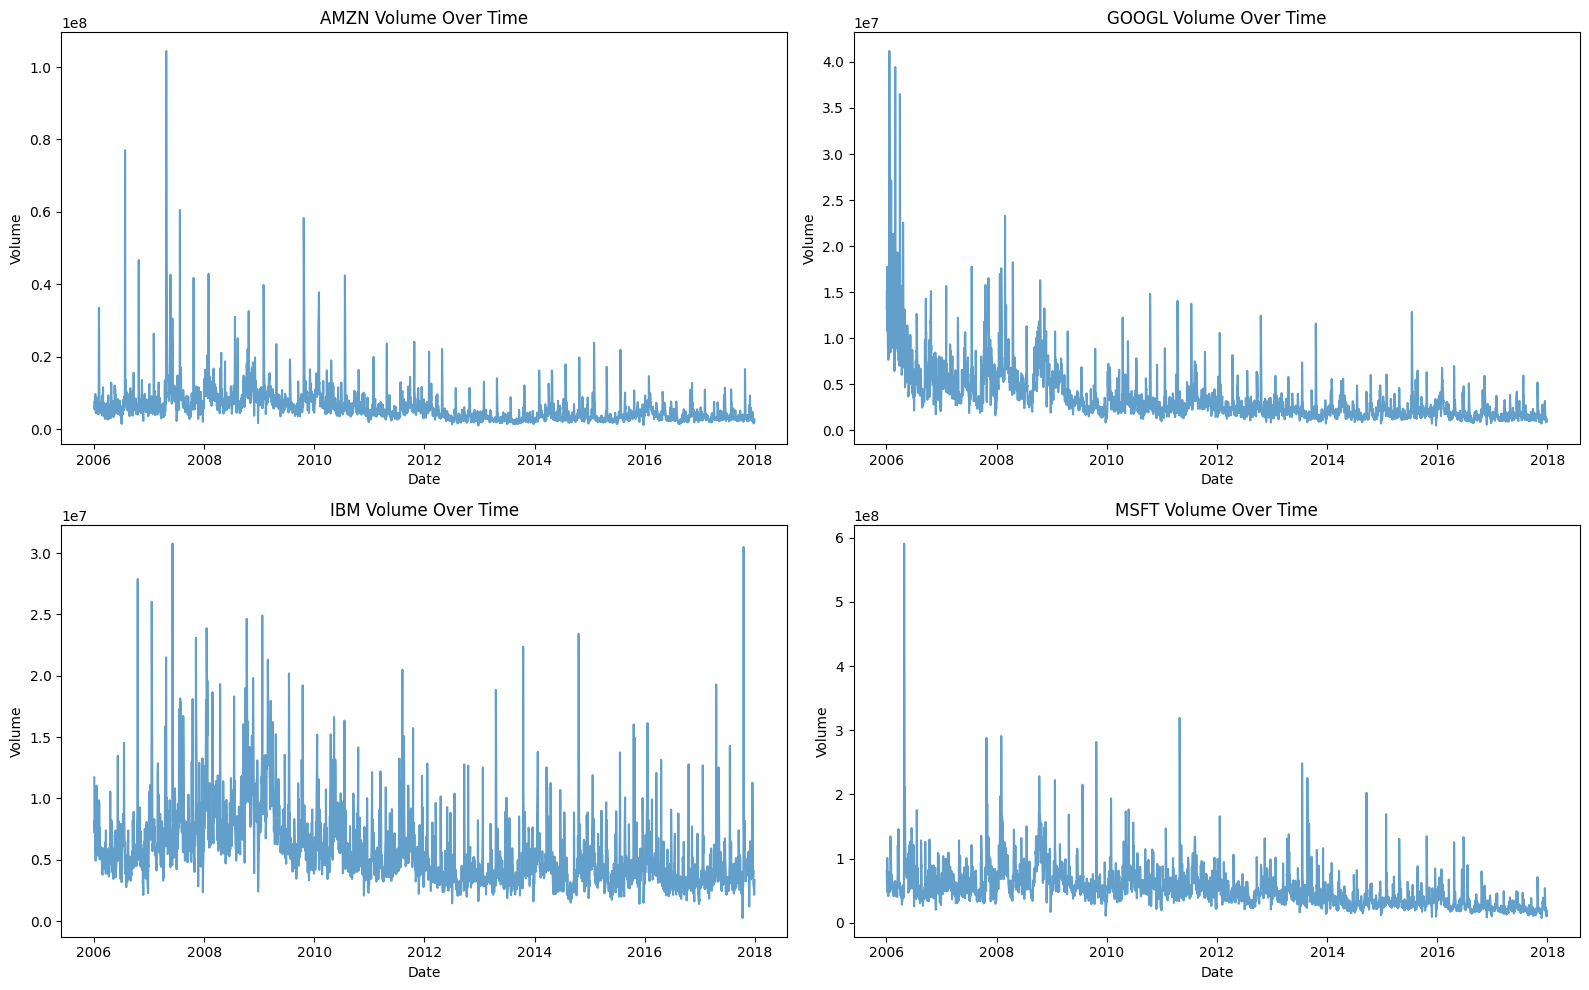

In [44]:
# Stock volume variation over time

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, company, vol_col, date_col in zip(axes.flatten(), companies, volume_cols, [f'Date_{c}' for c in companies]):
    ax.plot(pd.to_datetime(master_df[date_col]), master_df[vol_col], alpha=0.7)
    ax.set_title(f'{company} Volume Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')

plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

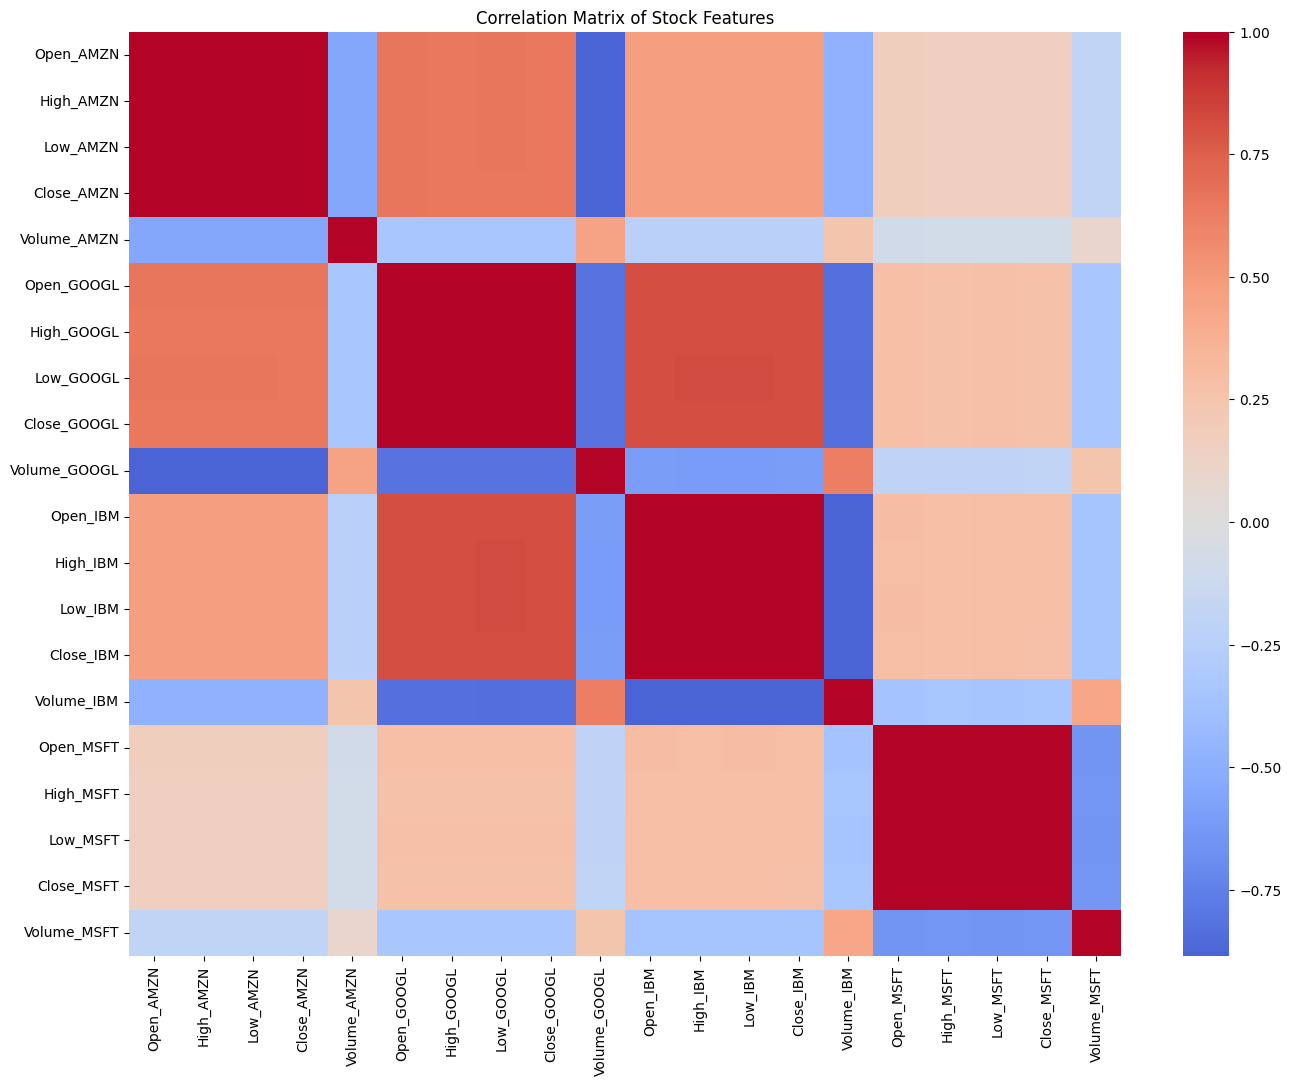

In [ ]:
# Analyse correlations

# Select only the numeric columns for correlation analysis
numeric_cols = master_df.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_cols.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Stock Features')
plt.show()


In [51]:
# Conclusion:
# From the correlation heatmap, we observe:
    # - Strong positive correlations among price features (Open, High, Low, Close) within each company.
    # - Moderate positive correlations between price features across different companies, indicating similar market trends.
    # - Trading volumes are generally negatively or weakly correlated with prices and with each other across companies.

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [52]:
# Define a function that divides the data into windows and generates target variable values for each window
def create_windowed_data(df, window_size=20, step_size=1, target_names=['AMZN']):
    """
    Splits the dataframe into windowed X and y arrays for time series prediction.

    Args:
        df (pd.DataFrame): The master dataframe.
        window_size (int): Number of time steps in each window.
        step_size (int): Stride for moving the window.
        target_names (list): List of stock names whose 'Close' values to predict.

    Returns:
        X_windows (np.ndarray): Array of shape (num_windows, window_size, num_features).
        y_windows (np.ndarray): Array of shape (num_windows, num_targets).
    """
    # Use only numeric columns for features
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    X_windows = []
    y_windows = []

    # Build target column names
    target_cols = [f'Close_{name}' for name in target_names]

    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        X_window = df.iloc[start:end][feature_cols].values
        y_window = df.iloc[end][target_cols].values if end < len(df) else None
        if y_window is not None:
            X_windows.append(X_window)
            y_windows.append(y_window)

    X_windows = np.array(X_windows)
    y_windows = np.array(y_windows)
    return X_windows, y_windows


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [53]:
from sklearn.preprocessing import StandardScaler

# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X_windows, y_windows):
    """
    Scales windowed X and y data using StandardScaler.
    Each feature is scaled across all windows and time steps.

    Args:
        X_windows (np.ndarray): Shape (num_windows, window_size, num_features)
        y_windows (np.ndarray): Shape (num_windows, num_targets)

    Returns:
        X_scaled (np.ndarray): Scaled X_windows
        y_scaled (np.ndarray): Scaled y_windows
        X_scaler (StandardScaler): Fitted scaler for X
        y_scaler (StandardScaler): Fitted scaler for y
    """
    num_windows, window_size, num_features = X_windows.shape

    # Reshape X to 2D for scaling: (num_windows * window_size, num_features)
    X_reshaped = X_windows.reshape(-1, num_features)
    X_scaler = StandardScaler()
    X_scaled = X_scaler.fit_transform(X_reshaped)
    X_scaled = X_scaled.reshape(num_windows, window_size, num_features)

    # Scale y
    y_scaler = StandardScaler()
    y_scaled = y_scaler.fit_transform(y_windows)

    return X_scaled, y_scaled, X_scaler, y_scaler

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [55]:
# Define a function to create input and output data points from the master DataFrame
def prepare_rnn_data(master_df, target_names, window_size=20, step_size=1, test_size=0.2):
    """
    Prepares scaled and windowed train/test data for RNNs.

    Args:
        master_df (pd.DataFrame): The joined master data set.
        target_names (list): List of stock names to predict (e.g., ['AMZN']).
        window_size (int): Number of time steps in each window.
        step_size (int): Stride for moving the window.
        test_size (float): Fraction of data to use as test set.

    Returns:
        X_train, y_train, X_test, y_test: Scaled and split data ready for RNNs.
    """
    # Create windowed data
    X_windows, y_windows = create_windowed_data(
        master_df, window_size=window_size, step_size=step_size, target_names=target_names
    )

    # Split into train and test sets (no shuffling for time series)
    split_idx = int((1 - test_size) * len(X_windows))
    X_train, X_test = X_windows[:split_idx], X_windows[split_idx:]
    y_train, y_test = y_windows[:split_idx], y_windows[split_idx:]

    # Scale the data
    X_train_scaled, y_train_scaled, X_scaler, y_scaler = scale_windowed_data(X_train, y_train)
    # Use the same scalers to transform test data
    num_windows_test, window_size_test, num_features = X_test.shape
    X_test_reshaped = X_test.reshape(-1, num_features)
    X_test_scaled = X_scaler.transform(X_test_reshaped).reshape(num_windows_test, window_size_test, num_features)
    y_test_scaled = y_scaler.transform(y_test)

    return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

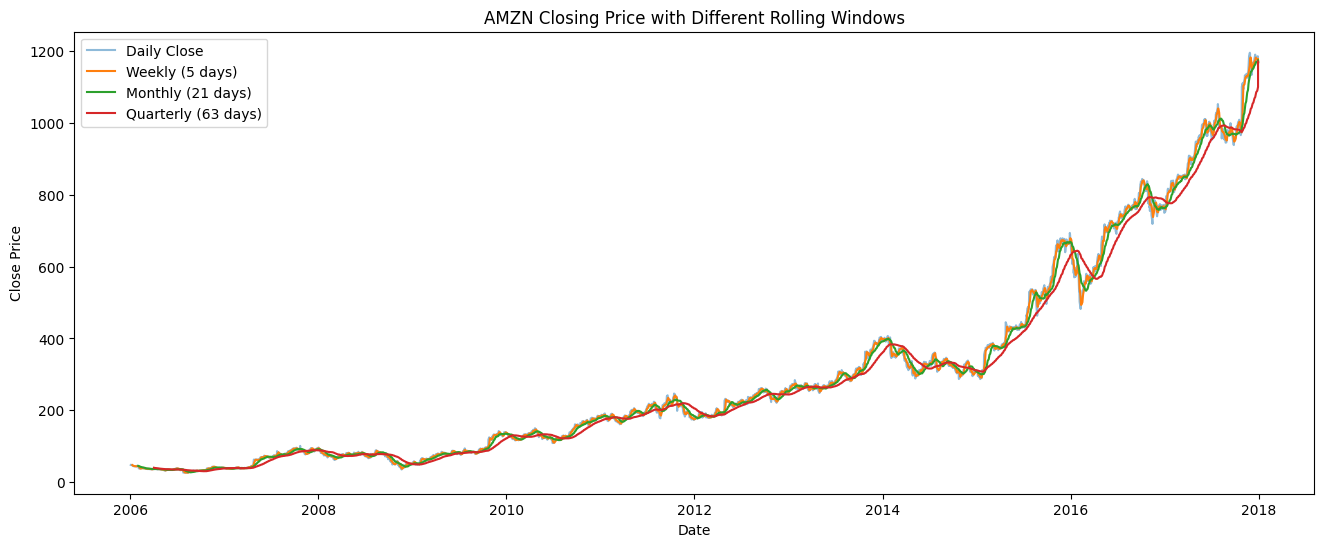

In [ ]:
# Checking for patterns in different sequence lengths

# AMZN
date_col = 'Date_AMZN'
close_col = 'Close_AMZN'

# Ensure date column is datetime
master_df[date_col] = pd.to_datetime(master_df[date_col])

plt.figure(figsize=(16, 6))
plt.plot(master_df[date_col], master_df[close_col], label='Daily Close', alpha=0.5)
plt.plot(master_df[date_col], master_df[close_col].rolling(window=5).mean(), label='Weekly (5 days)')
plt.plot(master_df[date_col], master_df[close_col].rolling(window=21).mean(), label='Monthly (21 days)')
plt.plot(master_df[date_col], master_df[close_col].rolling(window=63).mean(), label='Quarterly (63 days)')
plt.title('AMZN Closing Price with Different Rolling Windows')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
# Conclusion:
# A window size that best captures the repeating patterns in the data is typically around 63 days.
# This is because:
# - It captures quarterly trends, which are significant in stock markets.
# - It smooths out daily fluctuations while still being responsive to changes.
# - It balances between capturing short-term volatility and long-term trends.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [58]:
# Decide on window size and step size based on previous analysis
window_size = 63
step_size = 1  

# Prepare data for predicting AMZN closing price
target_names = ['AMZN','GOOGL', 'IBM', 'MSFT']

X_train, y_train, X_test, y_test = prepare_rnn_data(
    master_df,
    target_names=target_names,
    window_size=window_size,
    step_size=step_size,
    test_size=0.2
)



In [59]:
# Check the number of data points generated
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])
print("Shape of each training sample (window):", X_train.shape[1:])
print("Shape of each testing sample (window):", X_test.shape[1:])

Number of training samples: 9611
Number of testing samples: 2403
Shape of each training sample (window): (63, 20)
Shape of each testing sample (window): (63, 20)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [60]:
# Check if the datasets are compatible inputs to neural networks

# Check shapes and dtypes for neural network compatibility
print("X_train shape:", X_train.shape, "| dtype:", X_train.dtype)
print("y_train shape:", y_train.shape, "| dtype:", y_train.dtype)
print("X_test shape:", X_test.shape, "| dtype:", X_test.dtype)
print("y_test shape:", y_test.shape, "| dtype:", y_test.dtype)

# Typical requirements:
# - X: 3D array (samples, timesteps, features)
# - y: 2D array (samples, targets) or 1D if single target
assert X_train.ndim == 3, "X_train should be 3D"
assert X_test.ndim == 3, "X_test should be 3D"
assert y_train.ndim == 2, "y_train should be 2D"
assert y_test.ndim == 2, "y_test should be 2D"
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of training samples"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in number of testing samples"
print("Datasets are compatible for neural network input.")

X_train shape: (9611, 63, 20) | dtype: float64
y_train shape: (9611, 4) | dtype: float64
X_test shape: (2403, 63, 20) | dtype: float64
y_test shape: (2403, 4) | dtype: float64
Datasets are compatible for neural network input.


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Create a function that creates a simple RNN model according to the model configuration arguments
def build_simple_rnn(input_shape, output_dim, rnn_units=32, dropout_rate=0.0, activation='tanh', optimizer='adam', loss='mse'):
    """
    Builds and compiles a simple RNN model.

    Args:
        input_shape (tuple): Shape of input (timesteps, features).
        output_dim (int): Number of output units (targets).
        rnn_units (int): Number of units in the SimpleRNN layer.
        dropout_rate (float): Dropout rate after RNN layer.
        activation (str): Activation function for RNN layer.
        optimizer (str): Optimizer for model compilation.
        loss (str): Loss function for model compilation.

    Returns:
        model (tf.keras.Model): Compiled RNN model.
    """
    model = Sequential()
    model.add(SimpleRNN(rnn_units, activation=activation, input_shape=input_shape))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(output_dim))
    model.compile(optimizer=optimizer, loss=loss)
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

# Find an optimal configuration of simple RNN

# Define hyperparameter grid
param_grid = {
    'rnn_units': [16, 32, 64],
    'dropout_rate': [0.0, 0.2],
    'activation': ['tanh', 'relu'],
    'batch_size': [32, 64],
    'epochs': [20]
}

input_shape = X_train.shape[1:]
output_dim = y_train.shape[1]

best_val_loss = float('inf')
best_params = None
best_model = None

for rnn_units in param_grid['rnn_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for activation in param_grid['activation']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    model = build_simple_rnn(
                        input_shape=input_shape,
                        output_dim=output_dim,
                        rnn_units=rnn_units,
                        dropout_rate=dropout_rate,
                        activation=activation
                    )
                    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
                    history = model.fit(
                        X_train, y_train,
                        validation_split=0.2,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=0,
                        callbacks=[es]
                    )
                    val_loss = min(history.history['val_loss'])
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_params = {
                            'rnn_units': rnn_units,
                            'dropout_rate': dropout_rate,
                            'activation': activation,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }
                        best_model = model

print("Best validation loss:", best_val_loss)
print("Best hyperparameters:", best_params)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best validation loss: 0.5060751438140869
Best hyperparameters: {'rnn_units': 64, 'dropout_rate': 0.0, 'activation': 'relu', 'batch_size': 32, 'epochs': 20}


In [63]:
# Find the best configuration based on evaluation metrics

# Evaluate the best model on the test set
test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print("Test loss (MSE) of best model:", test_loss)
print("Best hyperparameters:", best_params)

Test loss (MSE) of best model: 44.55128479003906
Best hyperparameters: {'rnn_units': 64, 'dropout_rate': 0.0, 'activation': 'relu', 'batch_size': 32, 'epochs': 20}


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [64]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Retrain the best model on the full training set with optimal hyperparameters
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=1
)

Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.8885e-04 - val_loss: 0.5126
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.0619e-04 - val_loss: 0.5231
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.1030e-04 - val_loss: 0.5254
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1924e-04 - val_loss: 0.4896
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9887e-04 - val_loss: 0.5026
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0634e-04 - val_loss: 0.4912
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.3559e-04 - val_loss: 0.4835
Epoch 8/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 4.0054e-04 - val_loss: 0.5034
Epoch 9/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.3777e-04 - val_loss: 0.4826
Epoch 10/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.4473e-04 - val_loss: 0.4673
Epoch 11/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5567e-04 - val_loss: 0.4703
Epoch 12

Plotting the actual vs predicted values

In [ ]:
# Predict on the test data and plot



It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set



### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters



#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration



#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set


Plotting the actual vs predicted values

In [ ]:
# Predict on the test data


## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.